In [ ]:
pip install gensim # pour le doc2vec

In [335]:
# --- CONFIGURATION OF COLORS ---

GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [336]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.parse import urlparse
import time
import random
import csv
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
import numpy as np
#nltk.download('punkt_tab') #: to uncomment if not already downloaded
#nltk.download('stopwords') #: to uncomment if not already downloaded
#nltk.download('wordnet')    #: to uncomment if not already downloaded
#nltk.download('omw-1.4')    #: to uncomment if not already downloaded

# ------------------------------------------------------------------------------------------------------------------------------

In [337]:
from bs4 import BeautifulSoup
from dateutil import parser
import re

def extract_date_from_html(html):
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator=" ", strip=True)

    date_patterns = [
        # Detect dates like : September 17, 2024 / Sep 17, 2024
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2},\s\d{4}\b',

        # Detect dates like : September 17 2024 
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2}\s\d{4}\b',

        # Detect dates like : 17 September 2024
        r'\b\d{1,2}\s(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|'
        r'Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|'
        r'Nov(?:ember)?|Dec(?:ember)?)\s\d{4}\b',

        # Detect dates like : 2024-09-17 (ISO)
        r'\b\d{4}-\d{2}-\d{2}\b',

        # Detect dates like : 09/17/2024 and 9/17/24 
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b'
    ]

    for pattern in date_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)  # Find all date strings in the text that match one of the date pattern
        for match in matches:  
            try:  # Try to convert the matched string into a date object to have all the dates with the same format
                date = parser.parse(match, fuzzy = False)  # Parse convert the match object into a datetime with a strict parsing (fuzzy = False -> takes only set apart dates, not dates in the text) 
                if 1990 <= date.year <= 2030:  # Keep only dates in a reasonable year range
                    return date
            except:
                continue  # If parsing fails, ignore this match and move to the next match

    return None


In [338]:
def content_date_csv_file(input_csv, output_csv, domain):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'html' not in df.columns:  # Verify that the html column exists
        raise ValueError(f"The html column is missing in: {input_csv}")
    
    df = df[df['url'].str.startswith(domain)]  # We want the content of the internal links (at least for mind body green)
    
    # Extract date from the html column
    df['date'] = df['html'].apply(extract_date_from_html)

    # Keep columns in the desired order with the 3 columns
    df = df[['url', 'date', 'html']]

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Create a new csv file

    return df

In [339]:
def get_corpus(html):
    soup = BeautifulSoup(html, "html.parser")
    paragraphs = [p.get_text(separator=" ", strip=True) for p in soup.find_all("p") if len(p.get_text(strip=True)) > 10]
    text = " ".join(paragraphs)
    return text

In [340]:
def corpus_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'html' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    df['corpus_text'] = df['html'].apply(get_corpus)  # Cleans the html column

    if 'date' in df.columns :
        df = df[['url', 'date', 'corpus_text']]  # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'corpus_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [341]:
def clean_html(html):
    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']):  # Supress any unessecary tags
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True)  # Collect all visible text
    text = re.sub(r'\s+', ' ', text)  # Supress any unecessary spaces

    return text

In [352]:
def clean_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df['cleaned_text'] = df['corpus_text'].fillna("").apply(clean_html)  # Cleans the html column

    if 'date' in df.columns :
        df = df[['url', 'date', 'cleaned_text']]  # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'cleaned_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [354]:
def normalize_html(text):
    text = text.lower()  # Convert all characters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text)  # Remove reference markers like [1], [23], etc.
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep only English letters and spaces (remove ponctuation, numbers, and everything that is not a letter)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip() 

In [357]:
def normalize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns:  # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['normalized_text'] = df['cleaned_text'].fillna("").apply(normalize_html)  # normalize the cleaned text

    if 'date' in df.columns :
        df = df[['url', 'date', 'normalized_text']]  # keep the url and normalized text 
    else : 
        df = df[['url', 'normalized_text']]
    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

In [415]:
custom_stopwords = {
    # High-frequency but uniteresting
    "one", "two", "first", "second", "new", "more", "most", "many", "much",
    "even", "still", "just", "really", "very", "well", "good", "great", "better",
    "every", "each", "some", "any", "another", "few", "several", "also", "like", "anti", "something",

    # Adverbes
    "often", "sometimes", "usually", "typically", "generally", "likely", "probably",
    "maybe", "perhaps", "always", "never", "already", "again", "soon", "now", "then",
    "various", "numerous", "multiple", "today", "yesterday", "tomorrow",
    "currently", "recently", "eventually", "rarely", "occasionally",

    # Generic verbs (not in standard stopwords)
    "get", "got", "make", "made", "take", "took", "use", "used", "using", "help", "helps",
    "see", "seen", "know", "known", "show", "shows", "say", "says", "said", "find", "found",

    # Generic nouns with low semantic value 
    "thing", "things", "stuff", "kind", "kinds", "type", "types", "way", "ways",
    "part", "parts", "area", "areas", "aspect", "aspects", "place", "places",
    "lot", "bit", "time", "day", "week", "month", "year",
    "someone", "anyone", "everyone", "nobody",

    # Mots de liaison ou de structure
    "however", "therefore", "thus", "though", "although", "because", "while", "since",
    "before", "after", "during", "when", "where", "whose", "which", "who", "whom",

    # For MBG
    "mindbodygreen", "mbg", "mind", "body", "green", "mindbody", "bodygreen", "mbg.com", "editor", "editors", "read", "reading",

    # Names
    "sarah", "regan", "amanda", "shayne", "kelly", "gansalves", "abby", "moore", "jason", "wachob", "julie", 
    "nguyen", "braelyn", "wood", "alisa", "cowell", "alexandra", "engler", "ava", "durgin", "carleigh", "ferrante", 
    "hannah", "margaret", "allen", "molly", "knudsen", "emma", "engler", "devon", "barrow", "eliza", "sullivan", 
    "loewe", "jamie", "scheinder", "frye", "lindsay", "boyers", "kelsea", "samson", "editorial", "jamie", "scheinder", "ryan", 
    "brady", "megan", "falk", "julia", "guerra", "stephanie", "eckelkamp", "india", "edwards"
}

In [416]:
stop_words = list(set(stopwords.words('english'))) + ["'s"]  # Load English stopwords with an "s" at their ending

#stem = nltk.stem.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def tokenize_html(text):
    tokens = nltk.word_tokenize(text)  # Transform the text into a list of words
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    #tokens = [stem.stem(token) for token in tokens]  # apply stemming (racinisation)

    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # apply lemmatization
    #tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]

    tokens = [t for t in tokens if len(t) > 1]  # Remove very short or meaningless tokens 
    tokens = [t for t in tokens if len(t) < 20]  # Remove very long or meaningless tokens 
    tokens = [t for t in tokens if t not in custom_stopwords]  #-> seulement si on a une custom list
    return tokens

In [417]:
def tokenize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns:  # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    df['tokenized_text'] = df['normalized_text'].fillna("").apply(tokenize_html)  # cleans the html colon

    if 'date' in df.columns :
        df = df[['url', 'date', 'tokenized_text']]  # keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'tokenized_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

# ----------------------------------------------------------------------------------------------------------------------------------

For Mind Body Green

In [348]:
content_date_MBG_csv = content_date_csv_file("data/MBG_raw_html.csv", "data/MBG_content_date.csv", domain="https://www.mindbodygreen.com/")

PS : pour feedpsots alors faudra créer une liste de domains avec les premiers liens trouvés

In [349]:
corpus_MBG_csv = corpus_csv_file("data/MBG_content_date.csv", "data/MBG_corpus.csv")

In [353]:
cleaned_MBG_csv = clean_csv_file("data/MBG_corpus.csv", "data/cleaned_MBG_corpus.csv")

In [358]:
normalized_MBG_csv = normalize_csv_file("data/cleaned_MBG_corpus.csv", "data/normalized_MBG_corpus.csv")

In [418]:
tokenized_MBG_csv = tokenize_csv_file("data/normalized_MBG_corpus.csv", "data/tokenized_MBG_corpus.csv")

For Wikipedia

In [550]:
corpus_wiki_csv = corpus_csv_file("data/wiki_raw_html.csv", "data/wiki_corpus.csv")

In [551]:
cleaned_wiki_csv = clean_csv_file("data/wiki_corpus.csv", "data/cleaned_wiki_corpus.csv")

In [552]:
normalized_wiki_csv = normalize_csv_file("data/cleaned_wiki_corpus.csv", "data/normalized_wiki_corpus.csv")

In [553]:
tokenized_wiki_csv = tokenize_csv_file("data/normalized_wiki_corpus.csv", "data/tokenized_wiki_corpus.csv")

In [554]:
print(len(tokenized_wiki_csv))

474


# ----------------------------------------------------------------------------------------------------------------------------------------------------------

## Term document matrix

In [555]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):
    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)  # The vocabulary contains all tokens appearing in the corpus. Each token is listed only once, even if it appears multiple times.

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}  # The dictionnary has the name of a document as a key and a counter of token frequency as value

    # Step 3: Construct the term-document matrix (a list of dictionnaries that is transform into pandas dataframe where each column corresponds to a token, each row to a document. Each dictionnary has a token as key and a list of the frequency of its number of appears in all documents as value)
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys())  

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0)  # Document frequency counts in how many documents each token appears

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq]  # We only keep tokens if they appears a minimum of times. This removes very rare tokens that may not be informative.

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq]  # We only keep tokens if they appears less than a maximum of times. This removes very common tokens that may be uninformative.

    vocabulary = td_matrix.columns.tolist()  # Update the vocabulary to include only the tokens kept after filtering.

    return td_matrix, vocabulary

In [420]:
MBG_tokenized_dict = dict(zip(tokenized_MBG_csv['url'], tokenized_MBG_csv['tokenized_text']))  # We transform the csv file with the tokenized text into a dictionnary to make it feet the function above seen in class

🌟 2) Règle générale (recommandée en NLP)
Pour un corpus de taille N documents :

✔️ min_doc_freq ≈ 0.5% à 1% de N
✔️ max_doc_freq ≈ 40% à 60% de N

In [421]:
MBG_td_matrix, MBG_vocab = build_term_document_matrix(MBG_tokenized_dict, min_doc_freq=4, max_doc_freq=400)

print(MBG_vocab[:20])
print(MBG_td_matrix)

['unlock', 'stabilize', 'advocate', 'peak', 'romance', 'recognition', 'spoke', 'hdl', 'equation', 'liquid', 'truly', 'membership', 'female', 'ensures', 'prefers', 'air', 'outline', 'letter', 'phenomenal', 'develops']
                                                    unlock  stabilize  \
https://www.mindbodygreen.com/partner/ikea               0          0   
https://www.mindbodygreen.com/articles/ever-hea...       0          0   
https://www.mindbodygreen.com/articles/how-to-r...       0          0   
https://www.mindbodygreen.com/articles/gua-sha-...       0          1   
https://www.mindbodygreen.com/articles/unexpect...       0          0   
...                                                    ...        ...   
https://www.mindbodygreen.com/articles/nuts-and...       0          0   
https://www.mindbodygreen.com/articles/best-ket...       0          0   
https://www.mindbodygreen.com/articles/the-12-m...       0          0   
https://www.mindbodygreen.com/articles/health-b...   

In [556]:
wiki_tokenized_dict = dict(zip(tokenized_wiki_csv['url'], tokenized_wiki_csv['tokenized_text']))

In [557]:
wiki_td_matrix, wiki_vocab = build_term_document_matrix(wiki_tokenized_dict, min_doc_freq=3, max_doc_freq=285)

print(wiki_vocab[:20])
print(wiki_td_matrix)

['stabilize', 'advocate', 'brothel', 'rinsing', 'romance', 'clergy', 'equation', 'liquid', 'sunglass', 'sabine', 'broadening', 'byzantine', 'distaste', 'female', 'cv', 'aborted', 'acidification', 'somatic', 'geometrical', 'coir']
                                                   stabilize  advocate  \
https://en.wikipedia.org/wiki/Greenhouse_gas               0         0   
https://en.wikipedia.org/wiki/Rome                         0         0   
https://en.wikipedia.org/wiki/Body_mass_index              0         0   
https://en.wikipedia.org/wiki/Building_insulation          0         0   
https://en.wikipedia.org/wiki/Fashion                      0         0   
...                                                      ...       ...   
https://en.wikipedia.org/wiki/Theodor_W._Adorno            0         0   
https://en.wikipedia.org/wiki/Urban_agriculture            0         0   
https://en.wikipedia.org/wiki/Transition_Towns             0         0   
https://en.wikipedia.org/wiki/

## TF-IDF

In [558]:
def tf_idf (td_matrix) :
    row_sums = td_matrix.sum(axis=1)  # Compute the total number of tokens in each document (= sum on the td_matrix's rows)
    tf = td_matrix.div(row_sums, axis=0)  # Compute Term Frequency (TF). Each term count is divided by the total number of tokens in the corresponding document (normalization). This accounts for differences in document length.
    df = (td_matrix > 0).sum(axis=0)  # Compute Document Frequency (DF). For each term (column of the td_matrix), count the number of documents in which the term appears at least once.
    N = td_matrix.shape[0]  # Compute the total number of documents. This corresponds to the number of rows in the td_matrix.
    idf = np.log((N) / (df))  # Compute the IDF (Specificity). Terms that appear in many documents receive a lower IDF, while rare terms receive a higher IDF, making them more informative.
    tf_idf = tf.mul(idf, axis=1)  # Multiply each item in the tf column by the IDF corresponding so that each term's TF is weighted by its IDF score.
    return(tf_idf)

In [423]:
MBG_tf_idf = tf_idf(MBG_td_matrix)
print(MBG_tf_idf)

                                                    unlock  stabilize  \
https://www.mindbodygreen.com/partner/ikea             0.0   0.000000   
https://www.mindbodygreen.com/articles/ever-hea...     0.0   0.000000   
https://www.mindbodygreen.com/articles/how-to-r...     0.0   0.000000   
https://www.mindbodygreen.com/articles/gua-sha-...     0.0   0.006497   
https://www.mindbodygreen.com/articles/unexpect...     0.0   0.000000   
...                                                    ...        ...   
https://www.mindbodygreen.com/articles/nuts-and...     0.0   0.000000   
https://www.mindbodygreen.com/articles/best-ket...     0.0   0.000000   
https://www.mindbodygreen.com/articles/the-12-m...     0.0   0.000000   
https://www.mindbodygreen.com/articles/health-b...     0.0   0.000000   
https://www.mindbodygreen.com/articles/higher-p...     0.0   0.000000   

                                                    advocate  peak  romance  \
https://www.mindbodygreen.com/partner/ikea  

In [62]:
# To help us visualize, we transform the urls into readable labels
def url_to_label(url):
    last_part = url.rstrip('/').split('/')[-1]  # We only keep the last part of the url
    label = ' '.join([word.capitalize() for word in last_part.replace('-', ' ').replace('_', ' ').split()])  # We delete unwanted element ("_") and replace them by a space. The following letter is set as a capital letter.
    return label

KeyError: 'label'

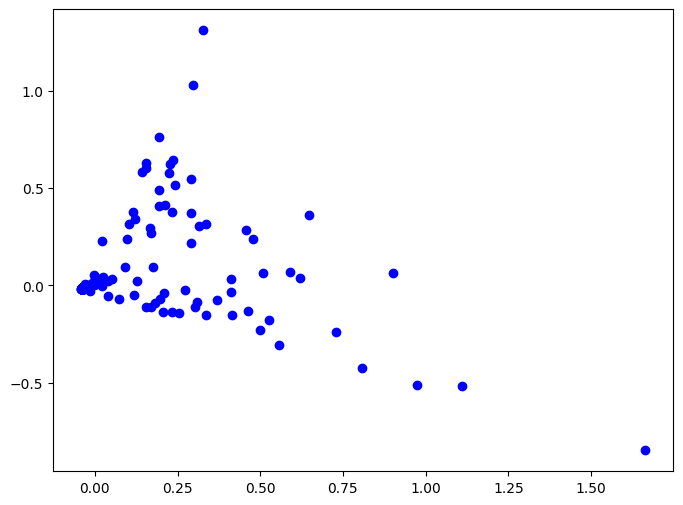

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Nettoyage obligatoire
MBG_tf_idf_clean = MBG_tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0)

# PCA
pca = PCA(n_components=2)
MBG_tf_idf_2d = pca.fit_transform(MBG_tf_idf_clean)

# DataFrame
MBG_tf_idf_2d_df = pd.DataFrame(MBG_tf_idf_2d, columns=['x', 'y'], index=MBG_tf_idf_clean.index)
MBG_tf_idf_2d_df['label'] = MBG_tf_idf_2d_df.index.map(url_to_label)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(MBG_tf_idf_2d_df['x'], MBG_tf_idf_2d_df['y'], color='blue')

for _, row in MBG_tf_idf_2d_df.iterrows():
    plt.text(row['x']+0.003, row['y']+0.003, row['label'], fontsize=7)

plt.title("TF-IDF Visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [559]:
wiki_tf_idf = tf_idf(wiki_td_matrix)
print(wiki_tf_idf)

                                                   stabilize  advocate  \
https://en.wikipedia.org/wiki/Greenhouse_gas             0.0  0.000000   
https://en.wikipedia.org/wiki/Rome                       0.0  0.000000   
https://en.wikipedia.org/wiki/Body_mass_index            0.0  0.000000   
https://en.wikipedia.org/wiki/Building_insulation        0.0  0.000000   
https://en.wikipedia.org/wiki/Fashion                    0.0  0.000000   
...                                                      ...       ...   
https://en.wikipedia.org/wiki/Theodor_W._Adorno          0.0  0.000000   
https://en.wikipedia.org/wiki/Urban_agriculture          0.0  0.000000   
https://en.wikipedia.org/wiki/Transition_Towns           0.0  0.000000   
https://en.wikipedia.org/wiki/China                      0.0  0.000612   
https://en.wikipedia.org/wiki/Capitalism                 0.0  0.000540   

                                                   brothel  rinsing   romance  \
https://en.wikipedia.org/wiki/

## Similarity Matrix

In [424]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def similarity_matrix(tf_idf):
    #tf_idf_clean = tf_idf.dropna(axis=0, how='any')  # Remove rows with NaN values 
    #tf_idf_clean = tf_idf_clean[tf_idf_clean.sum(axis=1) != 0]  # Remove rows that are entirely zero (empty vectors)

    tf_idf_clean = tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0)  # Replace "NaN" with a 0

    # Compute the cosine similarity matrix
    similarity_matrix_tfidf = cosine_similarity(tf_idf_clean)  # Each value ranges from 0 (no similarity) to 1 (identical documents).

    # Convert to a DataFrame for better readability (optional)
    similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf_clean.index, columns=tf_idf_clean.index)  # Rows and columns are labeled with document identifiers (index)

    # Display the similarity DataFrame
    display(similarity_df_tfidf)
    return(similarity_df_tfidf)

In [425]:
MBG_similarity_matrix = similarity_matrix(MBG_tf_idf)
print(MBG_similarity_matrix)

,https://www.mindbodygreen.com/partner/ikea,https://www.mindbodygreen.com/articles/ever-heard-of-nature-rising-heres-why-you-should-be-doing-it,https://www.mindbodygreen.com/articles/how-to-reverse-skin-aging,https://www.mindbodygreen.com/articles/gua-sha-tools,https://www.mindbodygreen.com/articles/unexpected-ways-creatine-supports-sharper-healthier-brain,https://www.mindbodygreen.com/partner/serta-perfect-sleeper-x,https://www.mindbodygreen.com/articles/3-non-negotiables-for-women-who-want-to-age-with-strength,https://www.mindbodygreen.com/articles/best-grain-free-pasta,https://www.mindbodygreen.com/articles/strong-but-stiff-why-mobility-matters-just-as-much-as-muscle,https://www.mindbodygreen.com/articles/hidden-cost-of-over-productivity-and-how-to-find-true-joy,...,https://www.mindbodygreen.com/articles/6-tips-to-avoiding-inury-from-an-orthopedic-surgeon,https://www.mindbodygreen.com/articles/health-coach-vs-life-coach,https://www.mindbodygreen.com/articles/link-between-alzheimers-risk-and-lean-muscle-mass-52934a,https://www.mindbodygreen.com/articles/citicoline-improves-cognitive-function-in-dementia-patients-this-rare-neuronutrient,https://www.mindbodygreen.com/articles/study-finds-even-more-proof-that-yoga-can-help-decrease-anxiety,https://www.mindbodygreen.com/articles/nuts-and-seeds-with-the-highest-levels-of-magnesium,https://www.mindbodygreen.com/articles/best-keto-meal-delivery,https://www.mindbodygreen.com/articles/the-12-major-types-of-meditation-explained-simply,https://www.mindbodygreen.com/articles/health-benefits-of-nootropics,https://www.mindbodygreen.com/articles/higher-population-well-being-strongly-linked-with-lower-cvd-death-not-diet-excercise
https://www.mindbodygreen.com/partner/ikea,1.000000,0.018298,0.007235,0.006625,0.009899,0.0,0.003660,0.047320,0.013606,0.018621,...,0.000959,0.008043,0.000000,0.003461,0.000000,0.000790,0.016102,0.002903,0.012035,0.002200
https://www.mindbodygreen.com/articles/ever-heard-of-nature-rising-heres-why-you-should-be-doing-it,0.018298,1.000000,0.028176,0.015595,0.037429,0.0,0.037977,0.005519,0.030519,0.030068,...,0.025567,0.010836,0.036632,0.059342,0.026302,0.011962,0.017646,0.051456,0.068782,0.064597
https://www.mindbodygreen.com/articles/how-to-reverse-skin-aging,0.007235,0.028176,1.000000,0.095704,0.040150,0.0,0.070484,0.039309,0.044019,0.038095,...,0.035357,0.024942,0.030491,0.025818,0.033871,0.033092,0.023871,0.023294,0.048161,0.026016
https://www.mindbodygreen.com/articles/gua-sha-tools,0.006625,0.015595,0.095704,1.000000,0.007320,0.0,0.013872,0.008653,0.023252,0.014075,...,0.014615,0.011633,0.018427,0.009356,0.004438,0.008484,0.009280,0.038310,0.023121,0.025980
https://www.mindbodygreen.com/articles/unexpected-ways-creatine-supports-sharper-healthier-brain,0.009899,0.037429,0.040150,0.007320,1.000000,0.0,0.051012,0.017162,0.027458,0.021574,...,0.019815,0.014523,0.113218,0.159856,0.020655,0.012646,0.012577,0.022658,0.168054,0.014037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.mindbodygreen.com/articles/nuts-and-seeds-with-the-highest-levels-of-magnesium,0.000790,0.011962,0.033092,0.008484,0.012646,0.0,0.073578,0.134899,0.002311,0.013127,...,0.006196,0.005179,0.019089,0.006385,0.011532,1.000000,0.038714,0.011387,0.026947,0.016892
https://www.mindbodygreen.com/articles/best-keto-meal-delivery,0.016102,0.017646,0.023871,0.009280,0.012577,0.0,0.053364,0.107423,0.006800,0.025622,...,0.013352,0.021739,0.025725,0.014590,0.013953,0.038714,1.000000,0.016296,0.020145,0.021776
https://www.mindbodygreen.com/articles/the-12-major-types-of-meditation-explained-simply,0.002903,0.051456,0.023294,0.038310,0.022658,0.0,0.026801,0.010838,0.016252,0.037287,...,0.033357,0.031976,0.039048,0.015171,0.044418,0.011387,0.016296,1.000000,0.034425,0.024121
https://www.mindbodygreen.com/articles/health-benefits-of-nootropics,0.012035,0.068782,0.048161,0.023121,0.168054,0.0,0.031403,0.016864,0.059146,0.049010,...,0.032327,0.027587,0.102277

                                                    https://www.mindbodygreen.com/partner/ikea  \
https://www.mindbodygreen.com/partner/ikea                                            1.000000   
https://www.mindbodygreen.com/articles/ever-hea...                                    0.018298   
https://www.mindbodygreen.com/articles/how-to-r...                                    0.007235   
https://www.mindbodygreen.com/articles/gua-sha-...                                    0.006625   
https://www.mindbodygreen.com/articles/unexpect...                                    0.009899   
...                                                                                        ...   
https://www.mindbodygreen.com/articles/nuts-and...                                    0.000790   
https://www.mindbodygreen.com/articles/best-ket...                                    0.016102   
https://www.mindbodygreen.com/articles/the-12-m...                                    0.002903   
https://www.mindbody

In [426]:
def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(14, 11))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')

    #labels = [url_to_label(url) for url in similarity_df.columns]  # We labelized the document not with their full link but their label found with the function (url_to_label)
    
    ax = plt.gca()  # We set the axis to have them set at the right place
    #ax.set_xticks(range(len(labels)))
    #ax.set_yticks(range(len(labels)))
    #ax.set_xticklabels( labels, rotation=45, ha='right', rotation_mode='anchor', fontsize=7)
    #ax.set_yticklabels( labels, fontsize=7)

    ax.set_xticks([]) 
    ax.set_yticks([])
    
    ax.set_xlabel('Documents')
    ax.set_ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    """for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            ax.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')"""

    plt.tight_layout()

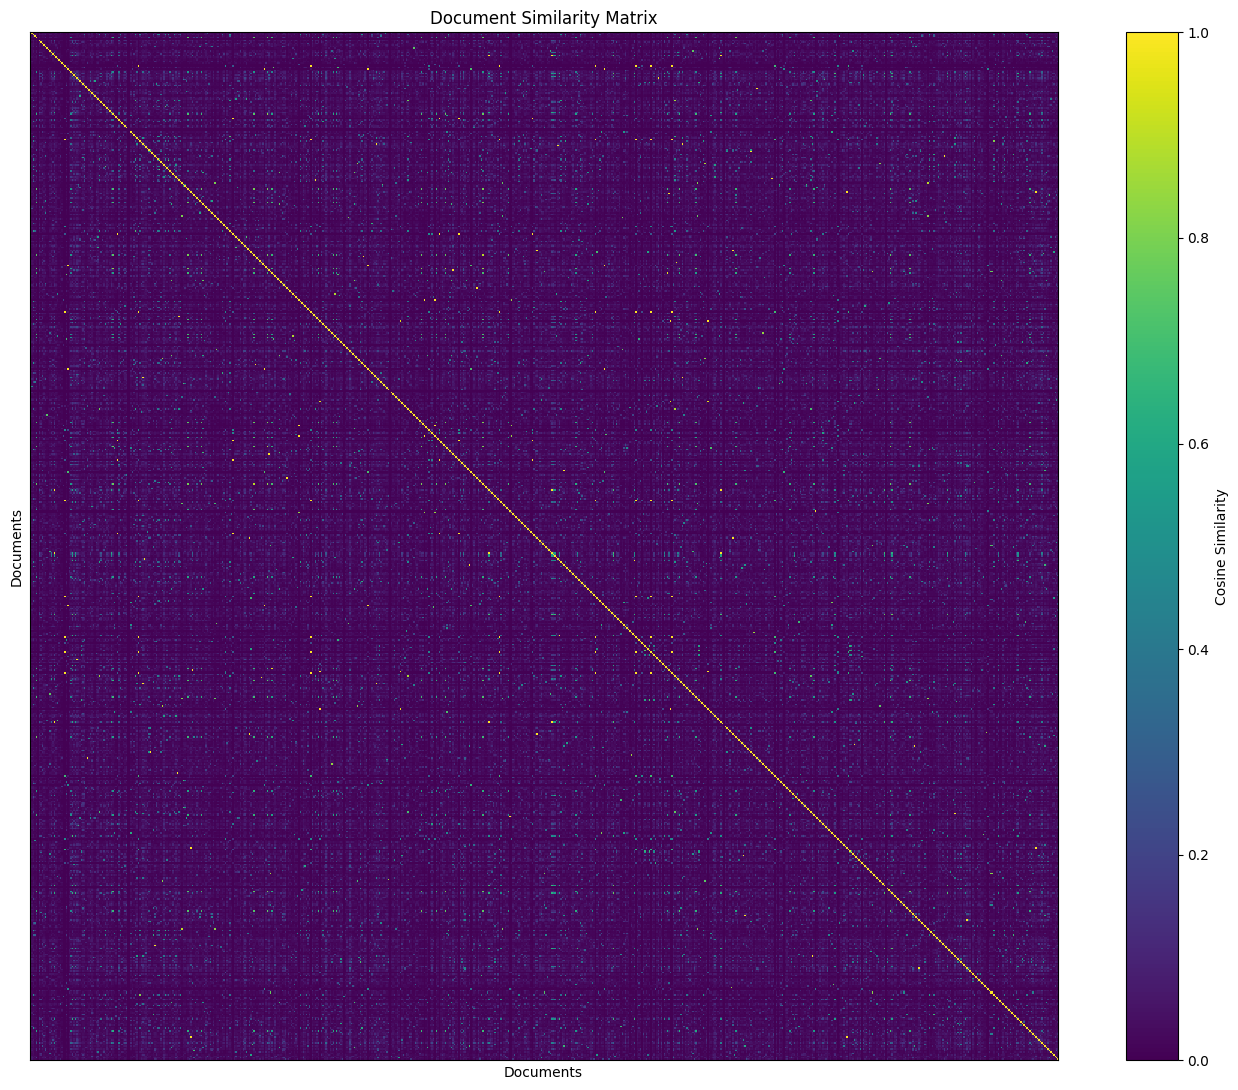

In [427]:
plot_similarity_matrix(MBG_similarity_matrix)

,https://en.wikipedia.org/wiki/Greenhouse_gas,https://en.wikipedia.org/wiki/Rome,https://en.wikipedia.org/wiki/Body_mass_index,https://en.wikipedia.org/wiki/Building_insulation,https://en.wikipedia.org/wiki/Fashion,https://en.wikipedia.org/wiki/World_Intellectual_Property_Organization,https://en.wikipedia.org/wiki/Pollution,https://en.wikipedia.org/wiki/Purchasing_power_parity,https://en.wikipedia.org/wiki/Exercise,https://en.wikipedia.org/wiki/Film_industry,...,https://en.wikipedia.org/wiki/Imperialism,https://en.wikipedia.org/wiki/Cowboy_boot,https://en.wikipedia.org/wiki/Carbon_dioxide,https://en.wikipedia.org/wiki/Watermelon,https://en.wikipedia.org/wiki/Car_dependency,https://en.wikipedia.org/wiki/Theodor_W._Adorno,https://en.wikipedia.org/wiki/Urban_agriculture,https://en.wikipedia.org/wiki/Transition_Towns,https://en.wikipedia.org/wiki/China,https://en.wikipedia.org/wiki/Capitalism
https://en.wikipedia.org/wiki/Greenhouse_gas,1.000000,0.013554,0.017696,0.071463,0.025891,0.018319,0.114295,0.021237,0.013683,0.012211,...,0.011776,0.002160,0.496580,0.006739,0.021790,0.004640,0.055303,0.023339,0.033239,0.014022
https://en.wikipedia.org/wiki/Rome,0.013554,1.000000,0.006608,0.014955,0.043958,0.043124,0.032159,0.016695,0.014837,0.050153,...,0.081912,0.005766,0.014291,0.012595,0.047417,0.016254,0.065294,0.033456,0.087249,0.026280
https://en.wikipedia.org/wiki/Body_mass_index,0.017696,0.006608,1.000000,0.005400,0.015572,0.007868,0.009142,0.016338,0.034987,0.003620,...,0.011179,0.005018,0.009463,0.006330,0.005489,0.004548,0.011905,0.005519,0.015633,0.005504
https://en.wikipedia.org/wiki/Building_insulation,0.071463,0.014955,0.005400,1.000000,0.017242,0.017534,0.035281,0.014121,0.013192,0.010699,...,0.015551,0.003129,0.047507,0.006923,0.031342,0.004676,0.032308,0.016605,0.022035,0.010847
https://en.wikipedia.org/wiki/Fashion,0.025891,0.043958,0.015572,0.017242,1.000000,0.040482,0.047289,0.017346,0.016606,0.041337,...,0.055764,0.066878,0.017726,0.018710,0.037616,0.022071,0.037419,0.029033,0.078417,0.032368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://en.wikipedia.org/wiki/Theodor_W._Adorno,0.004640,0.016254,0.004548,0.004676,0.022071,0.018035,0.010421,0.007562,0.006857,0.015732,...,0.023206,0.002880,0.005896,0.002975,0.009039,1.000000,0.010344,0.012618,0.021533,0.039940
https://en.wikipedia.org/wiki/Urban_agriculture,0.055303,0.065294,0.011905,0.032308,0.037419,0.041041,0.102995,0.028281,0.042719,0.019591,...,0.036581,0.005250,0.064163,0.034494,0.123432,0.010344,1.000000,0.101618,0.071220,0.045281
https://en.wikipedia.org/wiki/Transition_Towns,0.023339,0.033456,0.005519,0.016605,0.029033,0.033459,0.030548,0.017346,0.015394,0.042617,...,0.025353,0.004118,0.027927,0.009214,0.036489,0.012618,0.101618,1.000000,0.041219,0.019053
https://en.wikipedia.org/wiki/China,0.033239,0.087249,0.015633,0.022035,0.078417,0.089109,0.082387,0.062257,0.029439,0.073545,...,0.142456,0.007300,0.027998,0.034104,0.050189,0.021533,0.071220,0.041219,1.000000,0.070445


                                                   https://en.wikipedia.org/wiki/Greenhouse_gas  \
https://en.wikipedia.org/wiki/Greenhouse_gas                                           1.000000   
https://en.wikipedia.org/wiki/Rome                                                     0.013554   
https://en.wikipedia.org/wiki/Body_mass_index                                          0.017696   
https://en.wikipedia.org/wiki/Building_insulation                                      0.071463   
https://en.wikipedia.org/wiki/Fashion                                                  0.025891   
...                                                                                         ...   
https://en.wikipedia.org/wiki/Theodor_W._Adorno                                        0.004640   
https://en.wikipedia.org/wiki/Urban_agriculture                                        0.055303   
https://en.wikipedia.org/wiki/Transition_Towns                                         0.023339   
https://en

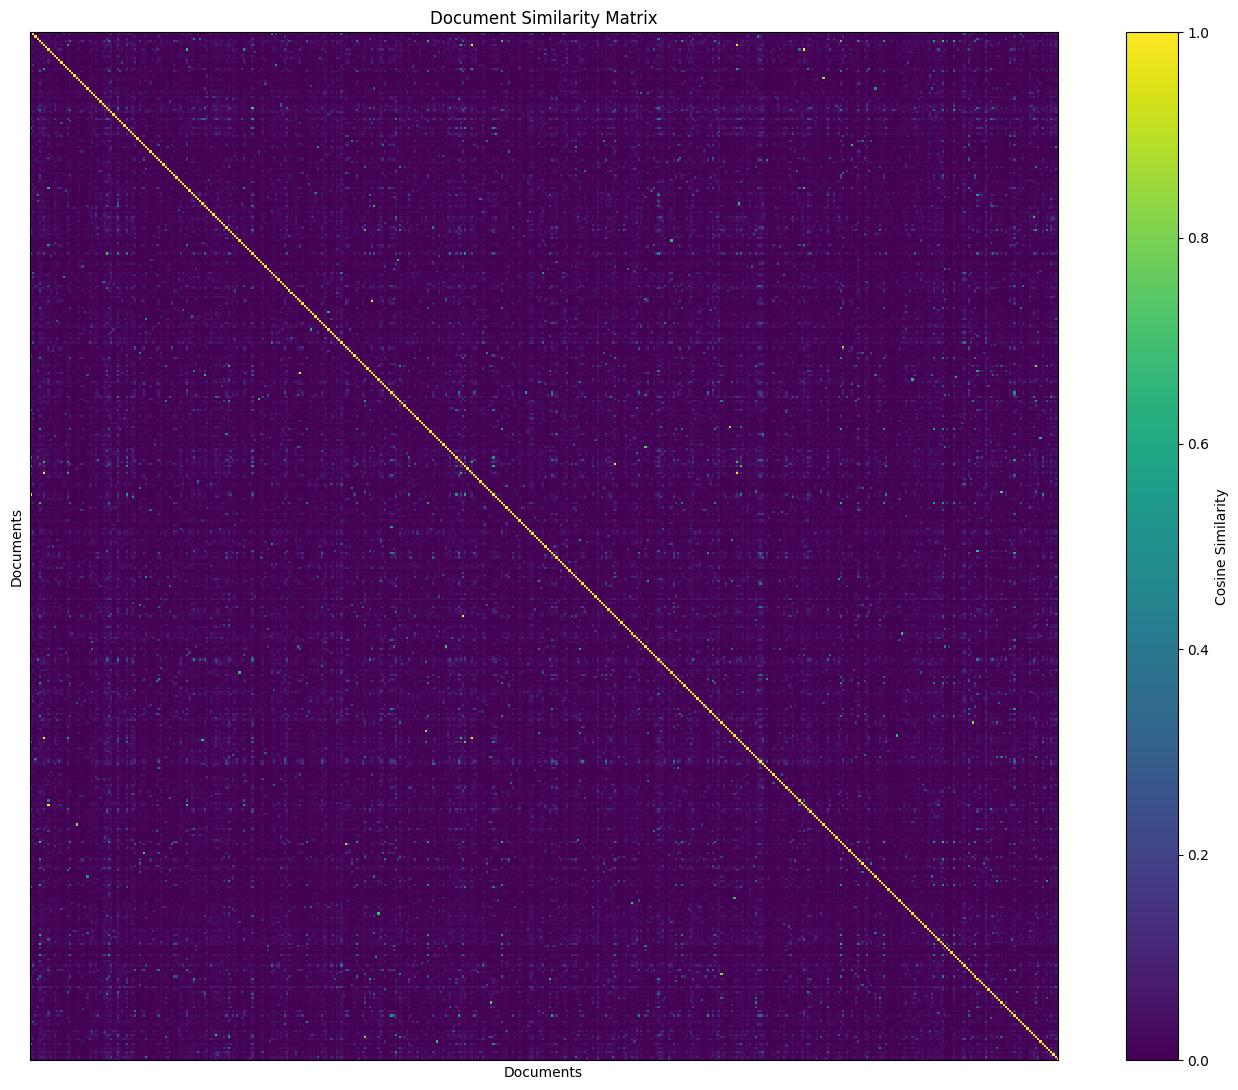

In [171]:
wiki_similarity_matrix = similarity_matrix(wiki_tf_idf)
print(wiki_similarity_matrix)
plot_similarity_matrix(wiki_similarity_matrix)

In [ ]:
# Sans les modifs de chat (= le code du prof) mais alors les axes déconne un peu

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix_tfidf = cosine_similarity(tf_idf)  # Each value ranges from 0 (no similarity) to 1 (identical documents).

# Convert to a DataFrame for better readability (optional)
similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf.index, columns=tf_idf.index)  # Rows and columns are labeled with document identifiers (index)

# Display the similarity DataFrame
display(similarity_df_tfidf)

def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(14, 11))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')

    labels = [url_to_label(url) for url in similarity_df.columns]  # We labelized the document not with their full link but their label found with the function (url_to_label)
    
    plt.xticks(ticks=range(len(similarity_df.columns)), labels = labels, rotation=45, fontsize=7)  
    plt.yticks(ticks=range(len(similarity_df.index)), labels = labels, fontsize=7)
    plt.xlabel('Documents')
    plt.ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            plt.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')

    plt.tight_layout()

plot_similarity_matrix(similarity_df_tfidf)


## Most frequent words

In [428]:
from collections import Counter

all_tokens = [tok for tokens in tokenized_MBG_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens
MBG_word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list
MBG_word_freq.most_common(20)  # Print only the 20 most frequent

[('health', 2474),
 ('protein', 2024),
 ('skin', 1921),
 ('muscle', 1867),
 ('food', 1633),
 ('sleep', 1232),
 ('support', 1220),
 ('need', 1181),
 ('supplement', 1155),
 ('product', 1149),
 ('may', 1117),
 ('people', 1072),
 ('brain', 1031),
 ('benefit', 1025),
 ('disease', 1013),
 ('level', 953),
 ('exercise', 939),
 ('feel', 936),
 ('high', 931),
 ('healthy', 902)]

In [429]:
all_tokens = [tok for tokens in tokenized_wiki_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens
wiki_word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list
wiki_word_freq.most_common(20)  # Print only the 20 most frequent

[('may', 4259),
 ('state', 3568),
 ('people', 3511),
 ('world', 3158),
 ('system', 3113),
 ('water', 2939),
 ('food', 2858),
 ('century', 2723),
 ('social', 2684),
 ('energy', 2681),
 ('country', 2629),
 ('th', 2619),
 ('city', 2585),
 ('health', 2530),
 ('study', 2431),
 ('high', 2276),
 ('including', 2155),
 ('disease', 2149),
 ('power', 2100),
 ('woman', 2090)]

## Words cloud

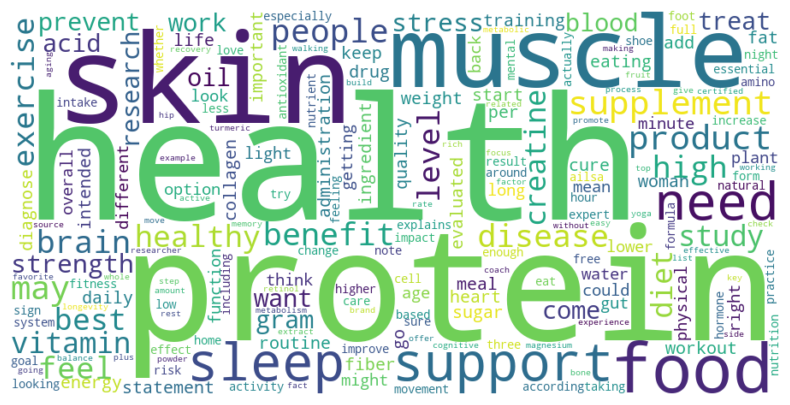

In [430]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud( width=900, height=450, background_color="white").generate_from_frequencies(MBG_word_freq)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

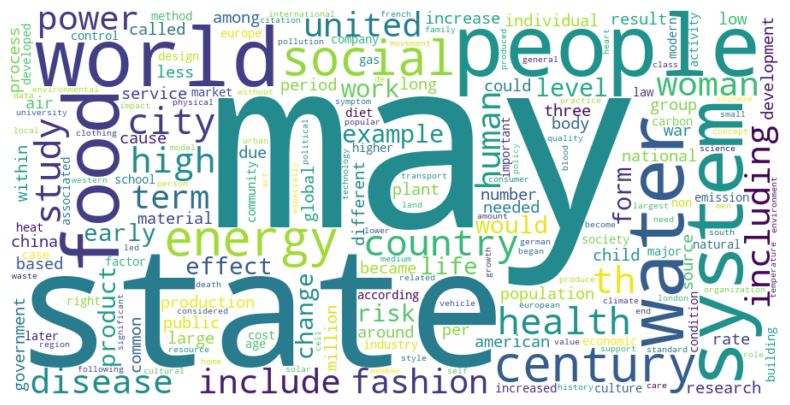

In [175]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud( width=900, height=450, background_color="white").generate_from_frequencies(wiki_word_freq)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Concordance
#### A supprimer ?

In [105]:
# A SUPPRIMER

def concordance(tokens, keyword, window=5):
    """
    Return a list of contexts where the keyword appears in the token list.
    Each context is a tuple: (left_context, keyword, right_context)
    """
    contexts = []
    for i, tok in enumerate(tokens):
        if tok == keyword:
            left = tokens[max(0, i-window):i]
            right = tokens[i+1:i+1+window]
            contexts.append((" ".join(left), keyword, " ".join(right)))
    return contexts

keyword = "stress"

for _, row in tokenized_MBG_csv.iterrows():
    # Ensure tokenized_text is a list of tokens
    tokens = row["tokenized_text"]
    if isinstance(tokens, str):
        # If stored as string, convert to list (split by space)
        tokens = tokens.split()
    for left, kw, right in concordance(tokens, keyword):
        print(f"[{row['url']}]")
        print(f"{left} >>{kw}<< {right}\n")


[https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max]
neurotrophic factor exercise linked lowering >>stress<< inducing hormone cortisol support better

[https://www.mindbodygreen.com/articles/supplements-for-stress]
 >>stress<< many thing life best moderation

[https://www.mindbodygreen.com/articles/supplements-for-stress]
output body brain high level >>stress<< time wendy suzuki ph brain

[https://www.mindbodygreen.com/articles/supplements-for-stress]
york university tell mbg along >>stress<< relieving practice exercise meditation supplement

[https://www.mindbodygreen.com/articles/supplements-for-stress]
bring body back baseline relieve >>stress<< build problem society suzuki put

[https://www.mindbodygreen.com/articles/supplements-for-stress]
society suzuki put co opted >>stress<< response constant external stimulation best

[https://www.mindbodygreen.com/articles/supplements-for-stress]
artificial sweetener synthetic dye included >>stress<< supplement priorit

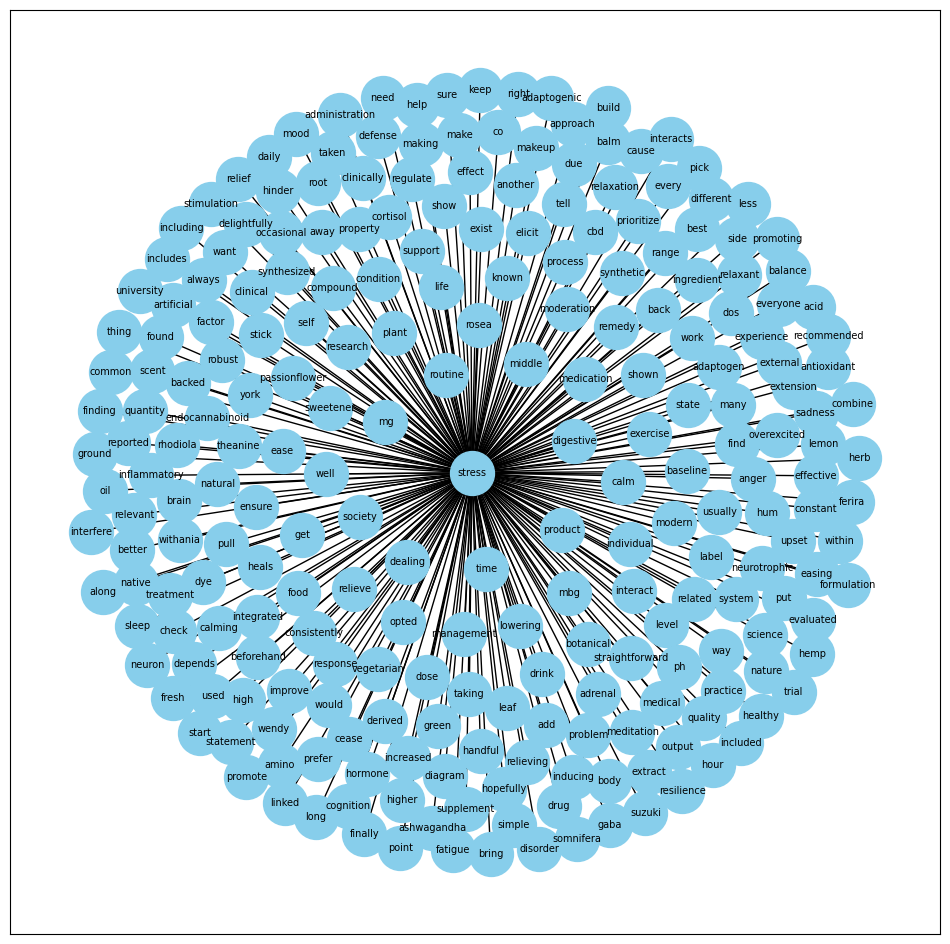

In [106]:
import networkx as nx

G = nx.Graph()

for _, row in tokenized_MBG_csv.iterrows():
    tokens = row["tokenized_text"]
    for left, kw, right in concordance(tokens, keyword):
        for word in left.split() + right.split():
            if word != kw:
                G.add_edge(kw, word)

plt.figure(figsize=(12,12))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=7)
plt.show()


## Cooccurence

In [ ]:
from collections import Counter
import pandas as pd
import itertools

def build_cooccurrence_matrix(tokenized_docs, top_n=None):
    """
    tokenized_docs : dict, {doc_id: [token1, token2, ...]}
    top_n : int, nombre de mots les plus fréquents à inclure (facultatif)

    Returns :
    cooc_df : DataFrame, matrice de cooccurrence (rows=cols=words)
    """
    # 1️⃣ Compter la fréquence de tous les mots
    all_tokens = [token for tokens in tokenized_docs.values() for token in tokens]
    token_counts = Counter(all_tokens)

    # Garder seulement les top_n mots si demandé
    if top_n is not None:
        top_tokens = [word for word, _ in token_counts.most_common(top_n)]
    else:
        top_tokens = list(token_counts.keys())

    # Construire la matrice de cooccurrence
    cooc_dict = {token: Counter() for token in top_tokens}

    for tokens in tokenized_docs.values():
        tokens_set = set(tokens) & set(top_tokens)  # limiter aux tokens sélectionnés
        for token1, token2 in itertools.combinations(tokens_set, 2):
            cooc_dict[token1][token2] += 1
            cooc_dict[token2][token1] += 1  # matrice symétrique

    # Convertir en DataFrame
    cooc_df = pd.DataFrame(cooc_dict).fillna(0).astype(int)
    return cooc_df

In [108]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_cooccurrence_graph(cooc_df, min_cooc=2):
    """
    cooc_df : DataFrame de cooccurrence
    min_cooc : int, seuil minimum pour afficher un lien
    """
    G = nx.Graph()

    # Ajouter les noeuds et les arêtes
    for word1 in cooc_df.columns:
        G.add_node(word1)
        for word2 in cooc_df.columns:
            weight = cooc_df.loc[word1, word2]
            if weight >= min_cooc:
                G.add_edge(word1, word2, weight=weight)

    # Positionnement
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Dessiner le graphe
    plt.figure(figsize=(12, 10))
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=[w*0.5 for w in weights], alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=7)
    plt.title('Graph of Word Cooccurrences')
    plt.axis('off')
    plt.show()


            max  stress  vo  body  health  fragrance  help  product  woman  \
disease       1       4   1     7       8          2     8       10      3   
sleep         1       2   1     5       4          2     4        5      1   
woman         1       3   1     1       3          0     3        3      0   
product       1       4   1     7       8          2     8        0      3   
high          1       2   1     6       5          2     5        6      1   
make          1       3   1     7       7          2     7        8      2   
way           1       3   1     6       7          1     6        7      2   
day           1       3   1     7       7          2     7        8      2   
health        1       4   1     6       0          1     7        8      3   
help          1       4   1     6       7          1     0        8      3   
stress        1       0   1     2       4          0     4        4      3   
well          1       3   1     7       7          2     7      

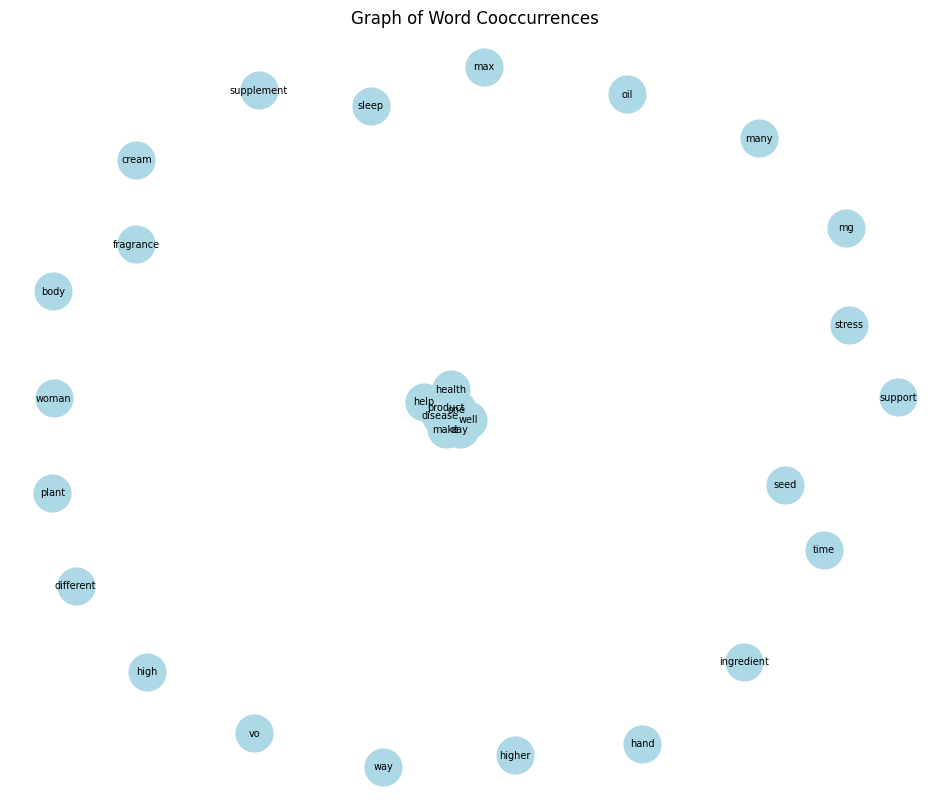

In [113]:
MBG_cooc = build_cooccurrence_matrix(tokenized_dict, top_n=30)
print(MBG_cooc)

plot_cooccurrence_graph(MBG_cooc, min_cooc=8)

## Analyse thématique MBG

In [375]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


In [432]:
import numpy as np
import pandas as pd

MBG_tf_idf_clean = MBG_tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0)

"""Pourquoi c’est bien ?
K‑means et PCA refusent les NaN → tu évites les crashs

Tu garantis un espace vectoriel propre

Tu évites les erreurs silencieuses"""

In [433]:
def plot_elbow(tf_idf, max_k=10):
    inertias = []
    n_docs = tf_idf.shape[0]
    max_k = min(max_k, n_docs - 1)
    K_values = range(2, max_k)

    for k in K_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tf_idf)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8,5))
    plt.plot(K_values, inertias, marker='o')
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertia (distortion)")
    plt.title("Méthode du coude (Elbow Method)")
    plt.grid(True)
    plt.show()

    # approx du "knee" : le point où la diminution ralentit le plus
    # on prend le point avec la plus grande "différence d'inertie" successive
    deltas = np.diff(inertias)
    best_k_idx = np.argmin(deltas) + 1  # +1 car diff décale de 1
    best_k = K_values[best_k_idx]
    best_inertia = inertias[best_k_idx]

    return best_k, best_inertia, K_values, inertias


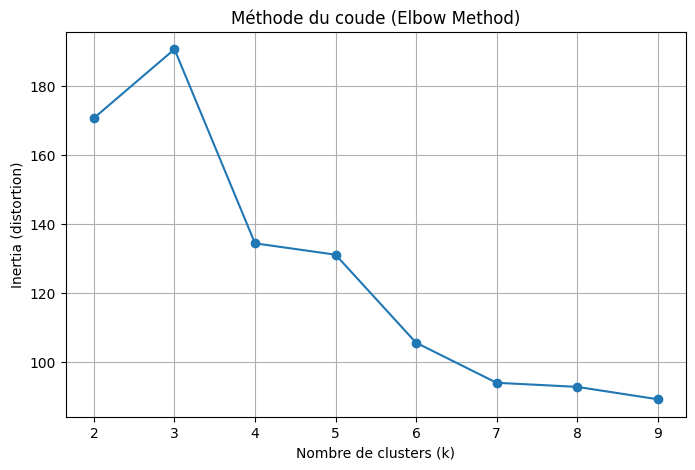

K idéal : 4
Inertia : 134.43739898107887


In [434]:
best_k, best_inertia, K_values, inertias = plot_elbow(MBG_tf_idf_clean, max_k=10)
print("K idéal :", best_k)
print("Inertia :", best_inertia)

In [435]:
from sklearn.metrics import silhouette_score

def plot_silhouette(tf_idf, max_k=10):
    scores = []
    n_docs = tf_idf.shape[0]
    max_k = min(max_k, n_docs - 1)
    K_values = range(2, max_k)

    for k in K_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(tf_idf)
        score = silhouette_score(tf_idf, labels)
        scores.append(score)

    plt.figure(figsize=(8,5))
    plt.plot(K_values, scores, marker='o')
    plt.xlabel("k")
    plt.ylabel("Silhouette score")
    plt.title("Méthode du Silhouette Score")
    plt.grid(True)
    plt.show()

    best_score = max(scores) 
    best_k = K_values[scores.index(best_score)] 
    return best_k, best_score, list(K_values), scores

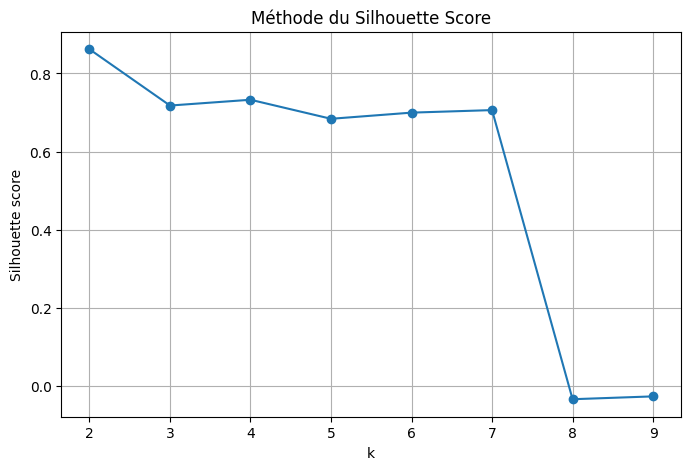

Best k : 2
Associated silhouette score : 0.861833781851677


In [436]:
best_k, best_score, ks, scores = plot_silhouette(MBG_tf_idf_clean) 
print("Best k :", best_k) 
print("Associated silhouette score :", best_score)

Attention : on prend 5 pour k et pas 4 parce que les clusters sont mesurés sur base de tokens (= pas de stopwords ou custom_stopwords) sauf que Bert est sur normalized_text et même si on prend dans vectorizer les stopwords, Bert ne les exclut pas donc on prend k+1 car un cluster sera pour les noms.

In [ ]:
MBG_k = 4
MBG_kmeans = KMeans(n_clusters=MBG_k, random_state=42)
MBG_tf_idf_clean['cluster'] = MBG_kmeans.fit_predict(MBG_tf_idf_clean)

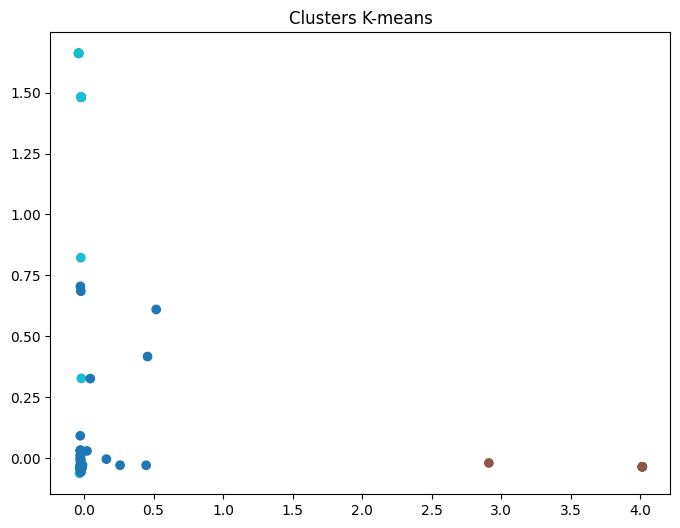

In [455]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
coords = pca.fit_transform(MBG_tf_idf_clean.drop(columns=['cluster']))

MBG_pca_df = pd.DataFrame(coords, columns=['x','y'], index=MBG_tf_idf_clean.index)

plt.figure(figsize=(8,6)) 
plt.scatter(MBG_pca_df['x'], MBG_pca_df['y'], c=MBG_tf_idf_clean['cluster'], cmap='tab10') 
plt.title("Clusters K-means") 
plt.show()

#### Bert

In [459]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def bertopic(normalized_corpus, vectorizer_model, cluster_model, min_words=100, embedding_model_name="all-MiniLM-L6-v2", nr_words=100):
    """
    Pipeline BERTopic avec KMeans (sans HDBSCAN), en forçant BERTopic
    à retourner plus que 10 mots par topic grâce à KeyBERTInspired.
    """

    # Load corpus
    df = pd.read_csv(normalized_corpus)
    documents = df["normalized_text"].astype(str).tolist()  # Make sure that every document is a string
    documents = [d for d in documents if len(d.split()) > min_words]  # remove documents with less than a x words (they are too short and only makes noise)

    # Embedding model
    embedding_model = SentenceTransformer(embedding_model_name)

    # Representation model forcing >10 words
    representation_model = KeyBERTInspired(top_n_words=nr_words)

    # BERTopic model
    topic_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model, hdbscan_model=cluster_model, representation_model=representation_model, verbose=True)

    # Fit and transform
    topics, probs = topic_model.fit_transform(documents)

    return topic_model, topics, probs, documents


In [460]:
full_stop_words = list(set(stop_words).union(custom_stopwords))

vectorizer_model = CountVectorizer( stop_words=full_stop_words, min_df=4, max_features=5000)

MBG_bert, MBG_topics, MBG_topics_probs, documents = bertopic( "data/normalized_MBG_corpus.csv", vectorizer_model=vectorizer_model, cluster_model=MBG_kmeans, min_words=100, embedding_model_name="all-MiniLM-L6-v2", nr_words=100)

print(len(documents))

2026-01-05 04:59:39,575 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 22/22 [00:40<00:00,  1.82s/it]
2026-01-05 05:00:19,991 - BERTopic - Embedding - Completed ✓
2026-01-05 05:00:19,992 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 05:00:21,451 - BERTopic - Dimensionality - Completed ✓
2026-01-05 05:00:21,453 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 05:00:21,469 - BERTopic - Cluster - Completed ✓
2026-01-05 05:00:21,476 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-05 05:00:23,569 - BERTopic - Representation - Completed ✓


673


In [560]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
# pip install hdbscan
import pandas as pd

def bertopic_hdbscan( normalized_corpus, min_words=30, embedding_model_name="all-MiniLM-L6-v2", nr_words=20, min_df=2, max_df=0.8, stop_words=None):
    """
    Pipeline BERTopic optimisé avec HDBSCAN.
    - Clustering naturel
    - Thèmes cohérents
    - Représentation KeyBERTInspired
    - Vectorizer calibré pour corpus MBG
    """

    # Load corpus
    df = pd.read_csv(normalized_corpus)
    documents = df["normalized_text"].astype(str).tolist()

    # Remove short documents
    documents = [d for d in documents if len(d.split()) >= min_words]

    # Embedding model
    embedding_model = SentenceTransformer(embedding_model_name)

    # Vectorizer
    vectorizer_model = CountVectorizer(
        stop_words=stop_words,
        min_df=min_df,
        max_df=max_df,
        max_features=5000
    )

    # Representation model
    representation_model = KeyBERTInspired(top_n_words=nr_words)

    # HDBSCAN clustering
    hdbscan_model = HDBSCAN(
        min_cluster_size=15,
        metric='euclidean',
        cluster_selection_method='eom'
    )

    # BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        verbose=True
    )

    # Fit + transform
    topics, probs = topic_model.fit_transform(documents)

    return topic_model, topics, probs, documents


In [467]:
full_stop_words = list(set(stop_words).union(custom_stopwords))

MBG_bert, MBG_topics, MBG_probs, MBG_docs = bertopic_hdbscan( "data/normalized_MBG_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=full_stop_words)

Documents conservés : 675


2026-01-05 05:11:05,897 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 22/22 [00:39<00:00,  1.79s/it]
2026-01-05 05:11:45,526 - BERTopic - Embedding - Completed ✓
2026-01-05 05:11:45,527 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 05:11:47,316 - BERTopic - Dimensionality - Completed ✓
2026-01-05 05:11:47,319 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 05:11:47,365 - BERTopic - Cluster - Completed ✓
2026-01-05 05:11:47,372 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-05 05:11:50,484 - BERTopic - Representation - Completed ✓


In [561]:
full_stop_words = list(set(stop_words).union(custom_stopwords))

wiki_bert, wiki_topics, wiki_probs, wiki_docs = bertopic_hdbscan( "data/normalized_wiki_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=full_stop_words)

2026-01-05 07:23:28,185 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it]
2026-01-05 07:23:58,449 - BERTopic - Embedding - Completed ✓
2026-01-05 07:23:58,451 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 07:23:59,337 - BERTopic - Dimensionality - Completed ✓
2026-01-05 07:23:59,340 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 07:23:59,370 - BERTopic - Cluster - Completed ✓
2026-01-05 07:23:59,377 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-05 07:24:04,736 - BERTopic - Representation - Completed ✓


In [ ]:
def summarize_topics(topic_model, top_words=3, max_words=100, min_score=0.075):
    """
    Résume les topics d'un modèle BERTopic :
    - Crée un nom simple pour chaque topic à partir des mots les plus importants
    - Note le nombre de documents par thème
    - Identifie le thème principal (topic avec le plus de documents)
    
    Parameters
    ----------
    topic_model : BERTopic
        Modèle BERTopic déjà entraîné.
    top_words : int
        Nombre de mots à utiliser pour créer le nom du thème.
    
    Returns
    -------
    themes : dict
        Dictionnaire {nom_du_thème : {"words": [...], "count": N_docs}}.
    main_theme : dict
        Infos du thème principal : {'topic_id', 'name', 'words', 'count'}.
    topic_df : pd.DataFrame
        DataFrame avec Topic ID, Count, Name.
    """
    
    # 1️⃣ Infos des topics
    topic_info = topic_model.get_topic_info()  # Topic, Count, Name
    topic_info = topic_info[topic_info.Topic != -1]  # ignorer les outliers

    main_topic_id = (
        topic_info.sort_values(by="Count", ascending=False)
        .Topic
        .iloc[0]
    )

    # 2️⃣ Créer le dictionnaire themes avec le nombre de documents
    themes = {}
    for topic_id in topic_info.Topic:
        words_scores = topic_model.get_topic(topic_id)
        # 🔥 filtrage par score + limite
        words = [
            word
            for word, score in words_scores
            if score >= min_score
        ][:max_words]
        #words = [w for w, _ in topic_model.get_topic(topic_id)]
        theme_name = ", ".join(words[:top_words])
        count_docs = topic_info.loc[topic_info.Topic == topic_id, "Count"].values[0]
        is_main_topic = (topic_id == main_topic_id)
        themes[theme_name] = {"keywords": words} 
        
        print(f"Theme: {theme_name}")                            
        print("Numbers of documents", count_docs)
        print(words)
        
        if is_main_topic:
            main_topic_words = words
            print("-> This is the main topic")

        print("-" * 40)

    
    # 4️⃣ Retourner un DataFrame complet
    topic_df = topic_info.copy()
    
    return themes, main_topic_words, topic_df

In [564]:
themes, main_topic_words, topic_df = summarize_topics(MBG_bert, top_words=3)

Theme: lifting, yoga, menopause
Numbers of documents 151
['lifting', 'yoga', 'menopause', 'cardio', 'treadmill', 'lift', 'glutes', 'protein', 'stronger', 'pilates', 'muscles', 'stability', 'weights', 'flexibility', 'exercises', 'benefits', 'stretching', 'posture', 'pushups', 'trainer', 'squat', 'cycling', 'stretches', 'train', 'hips', 'hip', 'joints', 'mobility', 'stretch', 'shoulders', 'spine', 'bone', 'core', 'vest', 'knees', 'knee', 'bike', 'challenging', 'movements', 'jumping', 'activities', 'injuries', 'pelvic', 'jump', 'comfortable', 'sport', 'machine', 'leg', 'injury', 'demonstrated', 'reduce', 'plank', 'arms']
-> This is the main topic
----------------------------------------
Theme: supplement, lean, protein
Numbers of documents 136
['supplement', 'lean', 'protein', 'keto', 'sugar', 'amino', 'metabolism', 'breakfast', 'nutrients', 'nutritional', 'consuming', 'dietary', 'intermittent', 'diets', 'carbohydrates', 'metabolic', 'fasting', 'nutrient', 'minerals', 'snack', 'carbs', 'w

In [562]:
themes, main_topic_words, topic_df = summarize_topics(wiki_bert, top_words=3)

Theme: cinema, edo, iran
Numbers of documents 103
['cinema', 'edo', 'iran', 'languages', 'discourse', 'speech', 'sociology', 'anthropology', 'allied', 'iranian', 'reforms', 'theatre', 'allies', 'philosophers', 'treaty', 'tokugawa', 'music', 'administrative', 'han', 'aesthetic', 'metropolitan', 'iraq', 'constitution', 'amsterdam', 'psychology', 'igbo', 'philosophical', 'literary', 'rulers', 'modernity', 'qing', 'parents', 'aesthetics', 'buddhism', 'artistic', 'conquest', 'pompeii', 'reform', 'ming', 'tao', 'elected', 'bourdieu', 'plato', 'dance', 'anatolia', 'caliphate', 'muslims']
-> This is the main topic
----------------------------------------
Theme: couture, textiles, apparel
Numbers of documents 77
['couture', 'textiles', 'apparel', 'textile', 'garment', 'garments', 'wearable', 'outfit', 'shirts', 'fabrics', 'shirt', 'dressed', 'additive', 'sweaters', 'fashions', 'costume', 'navy', 'outfits', 'sleeves', 'sex', 'luxury', 'fur', 'suits', 'dress', 'footwear']
------------------------

In [565]:
def filter_topic_words(main_topic_words):
    filtered_words = []
    for word in main_topic_words :
        if len(word) <= 2 :
            continue
        if word in full_stop_words :
            continue
        filtered_words.append(word)
    return filtered_words

In [566]:
main_topic_words_filtered = filter_topic_words(main_topic_words)
print(len(main_topic_words))
print(len(main_topic_words_filtered))
print(main_topic_words_filtered)

53
53
['lifting', 'yoga', 'menopause', 'cardio', 'treadmill', 'lift', 'glutes', 'protein', 'stronger', 'pilates', 'muscles', 'stability', 'weights', 'flexibility', 'exercises', 'benefits', 'stretching', 'posture', 'pushups', 'trainer', 'squat', 'cycling', 'stretches', 'train', 'hips', 'hip', 'joints', 'mobility', 'stretch', 'shoulders', 'spine', 'bone', 'core', 'vest', 'knees', 'knee', 'bike', 'challenging', 'movements', 'jumping', 'activities', 'injuries', 'pelvic', 'jump', 'comfortable', 'sport', 'machine', 'leg', 'injury', 'demonstrated', 'reduce', 'plank', 'arms']


In [567]:
import requests

def datamuse_synonyms(word):
    synonyms = set()

    # vrais synonymes
    url_syn = f"https://api.datamuse.com/words?rel_syn={word}"
    try:
        response = requests.get(url_syn, timeout=5).json()
        for item in response:
            if item.get("score", 0) > 500:
                synonyms.add(item["word"])
    except Exception:
        pass

    return list(synonyms)


In [572]:
from wordfreq import zipf_frequency
# pip install wordfreq

def is_real_word(word, threshold=1.5):
    # zipf_frequency renvoie 0 si le mot n'existe pas
    return zipf_frequency(word, "en") >= threshold

In [575]:
def expand_with_synonyms(word_list):
    expanded = set()

    for word in word_list:
        # 1) Toujours garder le mot original, sans filtrage
        expanded.add(word.lower())
        for variant in [word + "s", word + "ing", word + "ed"]:
            expanded.add(variant)

        # 2) Récupérer les synonymes
        syns = datamuse_synonyms(word)

        # 3) Filtrer uniquement les synonymes
        for s in syns:
            s = s.lower().strip()

            if is_real_word(s):
            # appliquer le filtre SEULEMENT aux synonymes
                if len(s) <= 2:
                    continue
                if s in full_stop_words:
                    continue
                if len(s.split()) > 1: 
                    continue

                expanded.add(s)

                for variant in [s + "s", s + "ing", s + "ed"]:
                    if is_real_word(variant):
                        expanded.add(variant)

    return sorted(expanded)


In [576]:
expanded_keywords = expand_with_synonyms(main_topic_words)

print("Nombre total de mots :", len(expanded_keywords))
print(expanded_keywords)

Nombre total de mots : 634
['abbreviate', 'abstract', 'abstracted', 'abstracting', 'abstracts', 'activities', 'activitiesed', 'activitiesing', 'activitiess', 'adulterate', 'airlift', 'airlifted', 'airlifting', 'airlifts', 'alternate', 'alternates', 'ambitious', 'annul', 'annuls', 'arise', 'arises', 'arms', 'armsed', 'armsing', 'armss', 'attitude', 'attitudes', 'auto', 'automobile', 'automobiles', 'autos', 'back', 'backbone', 'backbones', 'backed', 'backing', 'backs', 'bearing', 'bearings', 'benefits', 'benefitsed', 'benefitsing', 'benefitss', 'bicycle', 'bicycles', 'bike', 'bikeed', 'bikeing', 'bikes', 'blazon', 'blazoned', 'board', 'boarded', 'boarding', 'boards', 'boast', 'boasted', 'boasting', 'boasts', 'bone', 'boneed', 'boneing', 'bones', 'car', 'caravan', 'caravans', 'cardio', 'cardioed', 'cardioing', 'cardios', 'cared', 'caring', 'carriage', 'carriages', 'cars', 'cavort', 'cavorting', 'challenging', 'challenginged', 'challenginging', 'challengings', 'check', 'checked', 'checking

In [577]:
# Créer un DataFrame
df = pd.DataFrame({"main_topic_words_filtered": [expanded_keywords]})  # note les [ ] pour que ce soit UNE cellule

# Sauvegarder
df.to_csv("data/main_topic_words_filtered.csv", index=False)

## LDA

In [76]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = MBG_k  # Define the number of topics you want the LDA model to extract from the documents.
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)  # Create an LDA (Latent Dirichlet Allocation) model instance. random_state = seed for reproducibility (ensures the same results each time)

lda_model.fit(MBG_td_matrix)  # LDA learns the topic distributions for each document and the word distributions for each topic. We use term-document matrix as the vector for the LDA matrix (!! not tf-idf).

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",7
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [79]:
# A SUPPRIMER (??)

MBG_words = MBG_td_matrix.columns.tolist()
MBG_themes = {}

for topic_idx, topic in enumerate(lda_model.components_):
    distinctiveness = topic / lda_model.components_.sum(axis=0)
    top_idx = distinctiveness.argsort()[::-1][:3]
    topic_name = ", ".join(MBG_words[i] for i in top_idx)

    MBG_themes[topic_name] = [MBG_words[i] for i in topic.argsort()[::-1][:10]]

MBG_themes

{'shoe, mobility, injury': ['muscle',
  'body',
  'shoe',
  'strength',
  'support',
  'workout',
  'training',
  'foot',
  'exercise',
  'weight'],
 'pisces, gemini, scorpio': ['sign',
  'moon',
  'feel',
  'sleep',
  'life',
  'night',
  'work',
  'need',
  'feeling',
  'want'],
 'sarah, regan, braelyn': ['sarah',
  'regan',
  'wood',
  'braelyn',
  'engler',
  'alexandra',
  'ferrante',
  'carleigh',
  'devon',
  'barrow'],
 'oura, soriano, krista': ['sleep',
  'health',
  'light',
  'body',
  'stress',
  'red',
  'research',
  'study',
  'brain',
  'therapy'],
 'toy, cream, vibrator': ['skin',
  'brand',
  'water',
  'hair',
  'collagen',
  'toy',
  'ingredient',
  'feel',
  'come',
  'want'],
 'dating, eharmony, tinder': ['people',
  'relationship',
  'woman',
  'dating',
  'want',
  'app',
  'match',
  'life',
  'partner',
  'best'],
 'cheese, probiotic, fermented': ['protein',
  'meal',
  'health',
  'diet',
  'fiber',
  'gut',
  'healthy',
  'eating',
  'plant',
  'ingredient']

In [80]:
words = MBG_td_matrix.columns.tolist()  # Get the list of words (terms) corresponding to the columns of the td_matrix.
themes = {}  # Initialize an empty dictionary to store topics. Key = topic name (most frequent word), Value = set of top words for that topic.

for topic_idx, topic in enumerate(lda_model.components_):  # For each topic in the LDA model. lda_model.components_ is a matrix of shape (n_topics, n_words). Each row corresponds to a topic and contains the importance of each word for that topic.
    
    top_words_idx = topic.argsort()[::-1][:10]  # We keep only the 10 main words that have the most relevance (topic.argsort() sorts word indices in ascending order by their importance)
    top_words = [words[i] for i in top_words_idx]  # Convert the indices into actual word strings using the 'words' list.

    topic_name = top_words[0]   # We give a "name" to the topic (which is the most frequant word of the list)

    """topic_word_scores = lda_model.components_[topic_idx]
    distinctiveness = topic_word_scores / lda_model.components_.sum(axis=0)
    top_idx = distinctiveness.argsort()[::-1][:1]
    topic_name = ", ".join(words[i] for i in top_idx)"""

    themes[topic_name] = set(top_words)  # Store the topic in the dictionary.

print(themes) 

for name, words_set in themes.items():
    print(f"{name}: {words_set}")  # For a clearer view of the topics and their corresponding words

{'muscle': {'muscle', 'foot', 'exercise', 'strength', 'training', 'body', 'workout', 'weight', 'shoe', 'support'}, 'sign': {'sign', 'night', 'want', 'moon', 'life', 'work', 'need', 'feeling', 'feel', 'sleep'}, 'sarah': {'sarah', 'wood', 'carleigh', 'braelyn', 'devon', 'alexandra', 'barrow', 'engler', 'regan', 'ferrante'}, 'sleep': {'study', 'brain', 'body', 'light', 'research', 'stress', 'sleep', 'health', 'therapy', 'red'}, 'skin': {'brand', 'collagen', 'toy', 'skin', 'want', 'feel', 'come', 'water', 'ingredient', 'hair'}, 'people': {'app', 'partner', 'match', 'want', 'life', 'people', 'dating', 'woman', 'best', 'relationship'}, 'protein': {'diet', 'meal', 'plant', 'eating', 'healthy', 'protein', 'ingredient', 'health', 'fiber', 'gut'}}
muscle: {'muscle', 'foot', 'exercise', 'strength', 'training', 'body', 'workout', 'weight', 'shoe', 'support'}
sign: {'sign', 'night', 'want', 'moon', 'life', 'work', 'need', 'feeling', 'feel', 'sleep'}
sarah: {'sarah', 'wood', 'carleigh', 'braelyn', '

stress


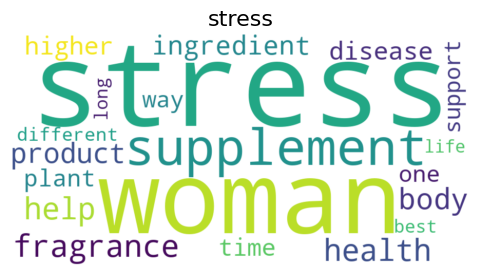

cream


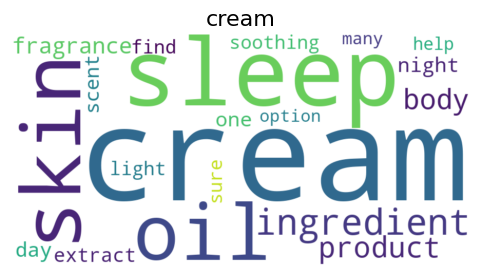

break


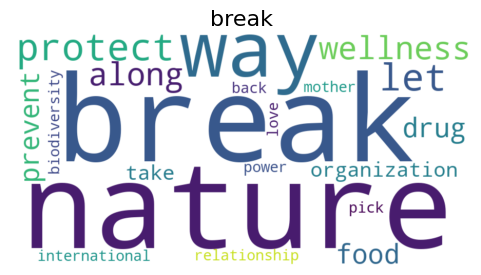

seed


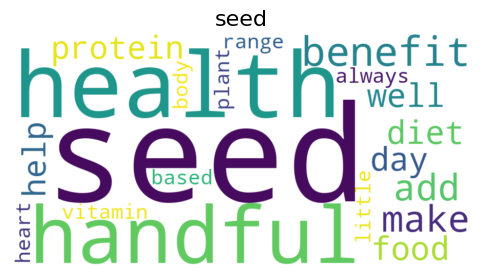

In [175]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creates a Word cloud for every topic

words = MBG_td_matrix.columns.tolist()

for topic_idx, topic in enumerate(lda_model.components_):
    # Get the top words and their scores
    top_words_idx = topic.argsort()[::-1][:20]  # top 20 words
    top_words = [words[i] for i in top_words_idx]
    word_freq = {words[i]: topic[i] for i in top_words_idx}  # word -> importance

    topic_name = top_words[0]
    print(topic_name)

    # Create the WordCloud
    wc = WordCloud( width=900, height=450, background_color="white").generate_from_frequencies(word_freq)

    # Display the WordCloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_name, fontsize=16, color='black')  # Topic name at the top
    plt.show()


Trouver les thèmes les pluc récurrents et les noms qu'on devrait leur donner

In [177]:
doc_topic_matrix = lda_model.transform(MBG_td_matrix)
theme_strength = doc_topic_matrix.sum(axis=0)
theme_order = theme_strength.argsort()[::-1]
print(theme_order)
print(theme_strength)

[0 1 3 2]
[4.81426218 3.14501251 1.02026906 1.02045625]


In [ ]:
""" Nommer le thème avec le mot le plus “distinctif”
Au lieu de prendre le mot le plus fréquent dans le thème, tu prends le mot qui :

est très important dans ce thème
mais peu important dans les autres thèmes
C’est ce qu’on appelle un mot discriminant. """

topic_word_scores = lda_model.components_[topic_idx]
distinctiveness = topic_word_scores / lda_model.components_.sum(axis=0)
top_idx = distinctiveness.argsort()[::-1][:4]
topic_name = ", ".join(words[i] for i in top_idx)
print(topic_name)

seed, handful, protein, immune


In [ ]:
# Nommer le thème avec les documents qui lui appartiennent
#Tu regardes les documents où ce thème est dominant, puis tu en extrais les mots les plus fréquents.

doc_topic = lda_model.transform(MBG_td_matrix)
dominant_docs = MBG_td_matrix.iloc[doc_topic[:, topic_idx].argsort()[::-1][:5]]
top_words = dominant_docs.sum().sort_values(ascending=False).head(4).index
topic_name = ", ".join(top_words)
print(topic_name)

seed, disease, woman, sleep


In [195]:
# ANALYSE CROISÉE K‑MEANS ↔ LDA

doc_topic = lda_model.transform(MBG_td_matrix)
"""LDA renvoie une matrice document → thèmes.
Chaque ligne = un document
Chaque colonne = un thème
Chaque valeur = probabilité que le document appartienne à ce thème"""

lda_dominant = doc_topic.argmax(axis=1) 
"""Pour chaque document, on prend le thème dominant (celui avec la probabilité la plus haute)."""

pd.crosstab(MBG_tf_idf_clean['cluster'], lda_dominant)
"""On compare :
les clusters K-means (géométriques)
les thèmes LDA (sémantiques)
C’est une matrice de correspondance."""


"""
col_0	0	1	2	3
cluster				
0	0	1	0	0
1	1	1	1	0
2	4	1	0	1

✔️ K-means et LDA ne racontent pas la même histoire
K-means regroupe selon la géométrie TF-IDF

LDA regroupe selon la distribution des mots

✔️ Ton tableau montre :
un cluster très cohérent (cluster 0)

un cluster très incohérent (cluster 1)

un cluster partiellement cohérent (cluster 2)

👉 Ton clustering n’est pas très aligné avec les thèmes LDA.

Ce n’est pas grave, mais ça montre que K-means n’est pas le meilleur outil pour détecter des thèmes dans un petit corpus."""

'\ncol_0\t0\t1\t2\t3\ncluster\t\t\t\t\n0\t0\t1\t0\t0\n1\t1\t1\t1\t0\n2\t4\t1\t0\t1\n\n✔️ K-means et LDA ne racontent pas la même histoire\nK-means regroupe selon la géométrie TF-IDF\n\nLDA regroupe selon la distribution des mots\n\n✔️ Ton tableau montre :\nun cluster très cohérent (cluster 0)\n\nun cluster très incohérent (cluster 1)\n\nun cluster partiellement cohérent (cluster 2)\n\n👉 Ton clustering n’est pas très aligné avec les thèmes LDA.\n\nCe n’est pas grave, mais ça montre que K-means n’est pas le meilleur outil pour détecter des thèmes dans un petit corpus.'

In [199]:
topic_names = list(themes.keys())

doc_topic = lda_model.transform(MBG_td_matrix)
lda_dominant = doc_topic.argmax(axis=1) 
cross = pd.crosstab(MBG_tf_idf_clean['cluster'], lda_dominant)

cross.columns = [topic_names[i] for i in cross.columns]
cross.index.name = "Clusters K-means" 
cross.columns.name = "Thèmes LDA"

print(cross)

Thèmes LDA        stress  cream  break  seed
Clusters K-means                            
0                      0      1      0     0
1                      1      1      1     0
2                      4      1      0     1


In [191]:
import pandas as pd

# Comparaison automatique K‑means ↔ LDA

def compare_kmeans_lda(tfidf_df, lda_model, td_matrix):
    """
    Compare les clusters K-means et les thèmes LDA.
    Retourne :
    - une matrice croisée
    - une interprétation automatique
    """

    # 1. Thème dominant par document (LDA)
    doc_topic = lda_model.transform(td_matrix)
    lda_dominant = doc_topic.argmax(axis=1)

    # 2. Cluster K-means déjà dans tfidf_df['cluster']
    clusters = tfidf_df['cluster']

    # 3. Matrice croisée
    cross = pd.crosstab(clusters, lda_dominant)

    print("=== Matrice croisée K-means ↔ LDA ===")
    print(cross)
    print()

    # 4. Interprétation automatique
    print("=== Interprétation automatique ===")
    for cluster_id in cross.index:
        row = cross.loc[cluster_id]
        dominant_topic = row.idxmax()
        count = row.max()

        print(f"- Cluster {cluster_id} → Thème LDA dominant : {dominant_topic} ({count} documents)")

    return cross


In [ ]:
compare_kmeans_lda(MBG_tf_idf_clean, lda_model, MBG_td_matrix)

=== Matrice croisée K-means ↔ LDA ===
col_0    0  1  2  3
cluster            
0        0  1  0  0
1        1  1  1  0
2        4  1  0  1

=== Interprétation automatique ===
- Cluster 0 → Thème LDA dominant : 1 (1 documents)
- Cluster 1 → Thème LDA dominant : 0 (1 documents)
- Cluster 2 → Thème LDA dominant : 0 (4 documents)


col_0,0,1,2,3
cluster,,,,
0,0,1,0,0
1,1,1,1,0
2,4,1,0,1


In [200]:
def get_theme_from_url(url, td_matrix, lda_model, topic_names):
    """
    Retourne le thème dominant associé à une URL déjà présente dans la td_matrix.
    
    url : str
        L'URL du document (clé de la td_matrix)
    td_matrix : DataFrame
        La matrice terme-document utilisée pour entraîner LDA
    lda_model : LatentDirichletAllocation
        Le modèle LDA déjà entraîné
    topic_names : list
        Liste ordonnée des noms de thèmes (ex: ["cortisol", "vo2", ...])
    """

    # Vérifier que l'URL existe dans la matrice
    if url not in td_matrix.index:
        raise ValueError(f"L'URL '{url}' n'existe pas dans la td_matrix.")

    # Extraire la ligne correspondant au document
    doc_vector = td_matrix.loc[url].values.reshape(1, -1)

    # Appliquer LDA sur ce document
    topic_distribution = lda_model.transform(doc_vector)[0]

    # Trouver le thème dominant
    dominant_topic_id = topic_distribution.argmax()

    # Retourner le nom du thème
    return topic_names[dominant_topic_id], topic_distribution

In [204]:
get_theme_from_url("https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal", MBG_td_matrix, lda_model, topic_names)

('stress',
 array([9.97200075e-01, 9.38531111e-04, 9.31780637e-04, 9.29613363e-04]))

In [ ]:
def nodes_theme(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'id' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The id column is missing in: {input_csv}")

    df['id'] = df['theme'].apply(get_theme_from_url)  # Cleans the html column
    df = df[['id', 'label', 'theme']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

## Analyse temporelle

In [139]:
from collections import Counter

def count_themes(tokens, themes):  # Count the number of times a theme (or associated word) appears in each document (/ doc's tokens)
    counts = Counter()
    token_set = set(tokens)
    for theme, keywords in themes.items():
        counts[theme] = len(token_set & keywords)
    return counts

In [140]:
timeline_MBG = tokenized_MBG_csv.copy()  # To be safer, we creat a copy of the dataframe
timeline_MBG ['date'] = pd.to_datetime(timeline_MBG['date'], errors='coerce')  # Transforms the dates into correct dates frame and if the data is not convertible it becomes "Not a Time"
timeline_MBG = timeline_MBG.dropna(subset=['date'])  # Delete all rows whith unvalid dates

In [141]:
rows = []

for i, row in timeline_MBG.iterrows():  # For every line in the dataframe (timeline_MBG)
    tokens = row['tokenized_text']  # Collect the tokens in the correct column

    theme_counts = count_themes(tokens, themes)  # Count the number of times the theme appears in the article's tokens

    for theme, count in theme_counts.items():  # For every theme and number of times it appears
        rows.append({ "date": row['date'],  "theme": theme, "count": count })  # Construction of a dictionnary for each date and for each theme and the number of times it appears

theme_timeline_MBG = pd.DataFrame(rows)  # Transform the list of dictionaaries in a dataframe

In [142]:
daily_evolution_timeline_MBG = ( theme_timeline_MBG
    .groupby(['date', 'theme'])['count']  # Group the datas (theme_timeline_MBG) according to their date and theme
    .sum()  # If multiples rows of theme_timeline_MBG has the same group (= same date and theme) it is sum to form only one row
    .reset_index()  # Important to not have the columns changed into date, theme (which is done automatically by groupby)
)

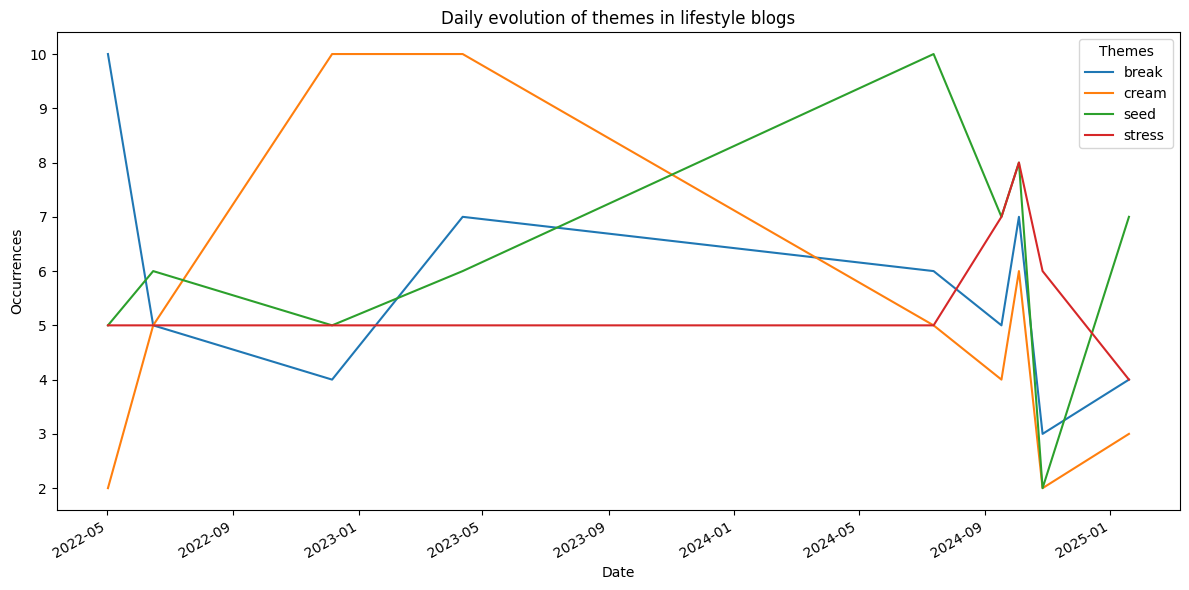

In [143]:
import matplotlib.pyplot as plt

# Pivot par jour
pivot = ( daily_evolution_timeline_MBG .pivot(index='date', columns='theme', values='count') .fillna(0))  # We pivot the table

# Plot
pivot.plot(figsize=(12,6))
plt.title("Daily evolution of themes in lifestyle blogs")
plt.xlabel("Date")
plt.ylabel("Occurrences")
plt.legend(title="Themes")
plt.tight_layout()
plt.show()


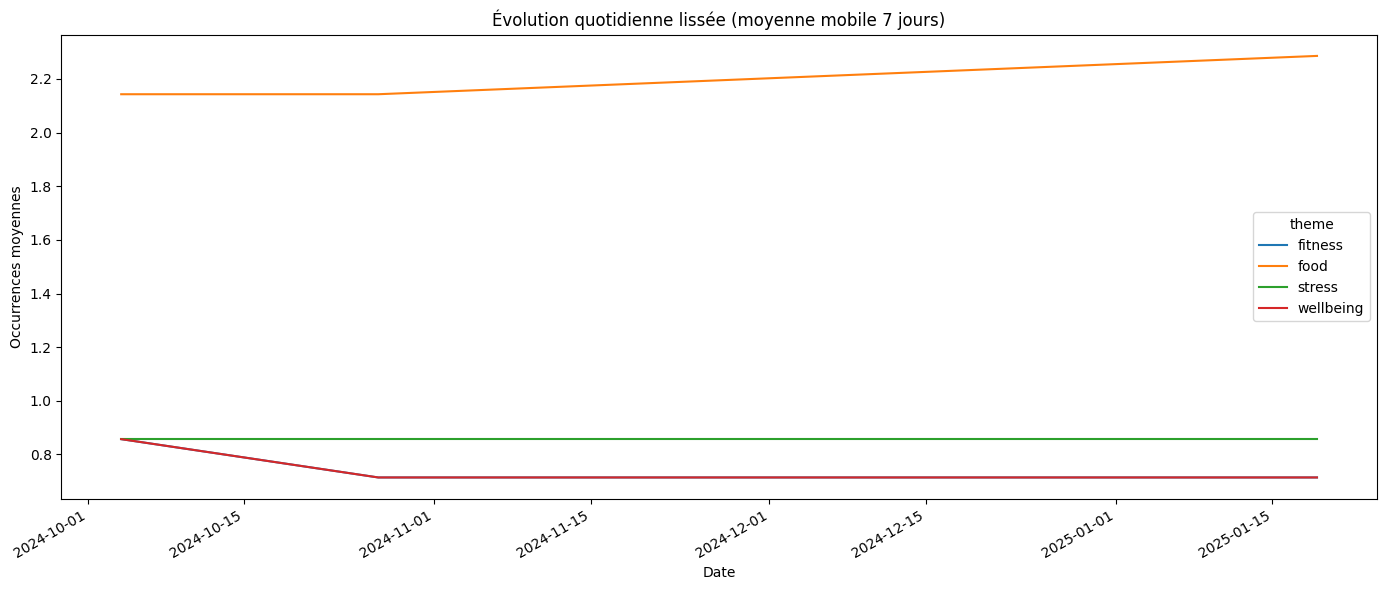

In [ ]:
# Lissage par moyenne mobile sur 7 jours  -> A supprimer
daily_smoothed = pivot.rolling(window=7).mean()

daily_smoothed.plot(figsize=(14,6))
plt.title("Évolution quotidienne lissée (moyenne mobile 7 jours)")
plt.xlabel("Date")
plt.ylabel("Occurrences moyennes")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Load corpus
df = pd.read_csv("data/normalized_MBG_corpus.csv")
documents = df["normalized_text"].astype(str).tolist()
documents = [d for d in documents if len(d.split()) > 100]  # remove documents with less than a 100 words (they are too short and only makes noise)

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # It transforms every document in a vector which have meaning 

# Vectorizer
vectorizer_model = CountVectorizer(
    stop_words="english",
    min_df=3,
    ngram_range=(1, 2)
)

# KMeans clustering (NO hdbscan)  -> clustering of documents per topic (we can ask for x cluster)
cluster_model = KMeans(
    n_clusters=6,
    random_state=42,
    n_init="auto"
)

# BERTopic without hdbscan
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=cluster_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)

print(topic_model.get_topic_info())

c:\Users\Violaine\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-03 10:46:14,797 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
2026-01-03 10:46:15,672 - BERTopic - Embedding - Completed ✓
2026-01-03 10:46:15,675 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-03 10:46:43,608 - BERTopic - Dimensionality - Completed ✓
2026-01-03 10:46:43,610 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-03 10:46:55,942 - BERTopic - Cluster - Completed ✓
2026-01-03 10:46:55,949 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-03 10:46:56,054 - BERTopic - Representation - Completed ✓


   Topic  Count                              Name  \
0      0      2       0_disease_women_health_long   
1      1      2        1_stress_help_ease_support   
2      2      2         2_products_like_body_able   
3      3      1        3_women_higher_health_just   
4      4      1             4_sleep_light_bed_day   
5      5      1  5_break_wellness_protect_provide   

                                      Representation  \
0  [disease, women, health, long, symptoms, time,...   
1  [stress, help, ease, support, root, healthy, b...   
2  [products, like, body, able, new, used, differ...   
3  [women, higher, health, just, body, improve, m...   
4  [sleep, light, bed, day, tech, uses, mind, way...   
5  [break, wellness, protect, provide, way, pick,...   

                                 Representative_Docs  
0  [women account for around of all cases of auto...  
1  [whether you live a plant based lifestyle or a...  
2  [hand creams are such a simple pleasure they p...  
3  [vo max used

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # We keep 2 dimensions to construct the graph
bert_2d = pca.fit_transform(topic_model)  # Compute the vectors in 2 D

bert_2d_df = pd.DataFrame(tf_idf_2d, columns=['x', 'y'], index=topic_model.index)  # Compute a dataframe pandas
bert_2d_df['label'] = bert_2d_df.index.map(url_to_label)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(bert_2d_df['x'], bert_2d_df['y'], color='blue')

# To delete if we don't want the labels
for _, row in bert_2d_df.iterrows():
    plt.text(row['x']+0.003, row['y']+0.003, row['label'], fontsize=7)

plt.title("TF-IDF Visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


TypeError: float() argument must be a string or a real number, not 'BERTopic'

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


silhouette_scores = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(topic_model)
    
    score = silhouette_score(topic_model, labels)
    silhouette_scores.append(score)

    print(f"k = {k} | Silhouette Score = {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score pour différents nombres de clusters")
plt.grid(True)
plt.show()


TypeError: float() argument must be a string or a real number, not 'BERTopic'

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Link analysis sur text mining

In [205]:
wiki_nodes_path = r"C:\Users\Violaine\OneDrive\Ecole\Master 1\Web mining\Projet Web Mining\Projet_Web_Mining\data\wikipedia_nodes.csv"
wiki_edges_path = r"C:\Users\Violaine\OneDrive\Ecole\Master 1\Web mining\Projet Web Mining\Projet_Web_Mining\data\wikipedia_edges.csv"

wiki_nodes = pd.read_csv(wiki_nodes_path)
wiki_edges = pd.read_csv(wiki_edges_path)

In [206]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ Charger les données
# ---------------------------

G = nx.DiGraph()
# Ajouter les nœuds avec l'attribut thème
for idx, row in wiki_nodes.iterrows():
    G.add_node(row['id'], theme=row['label'])  # A changer par theme !!

# Ajouter les liens
for idx, row in wiki_edges.iterrows():
    G.add_edge(row['source'], row['target'])

In [207]:
# Compter liens intra-thème et inter-thème  
intra = 0
inter = 0

for u, v in G.edges():
    if G.nodes[u]['theme'] == G.nodes[v]['theme']:
        intra += 1
    else:
        inter += 1

total_links = G.number_of_edges()
print(f"Liens intra-thème : {intra} ({intra/total_links:.2%})")  # -> Homophilie thématique
print(f"Liens inter-thème : {inter} ({inter/total_links:.2%})")

Liens intra-thème : 0 (0.00%)
Liens inter-thème : 1701 (100.00%)


In [ ]:
pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
indegree = dict(G.in_degree())

## Analyse thématique Wikipedia